[yfinance_fix] Patch erfolgreich angewendet.
[yfinance_fix] Chrome-Session erstellt.
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Index(['Volume', 'MACD_HIST', 'Target'], dtype='object', name='Price')
Optimization terminated successfully.
         Current function value: 0.689668
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                 8281
Model:                          Logit   Df Residuals:                     8278
Method:                           MLE   Df Model:                            2
Date:                Mon, 22 Dec 2025   Pseudo R-squ.:               0.0001644
Time:                        11:58:39   Log-Likelihood:                -5711.1
converged:                       True   LL-Null:                       -5712.1
Covariance Type:            nonrobust   LLR p-value:                    0.3910
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1440      0.030     

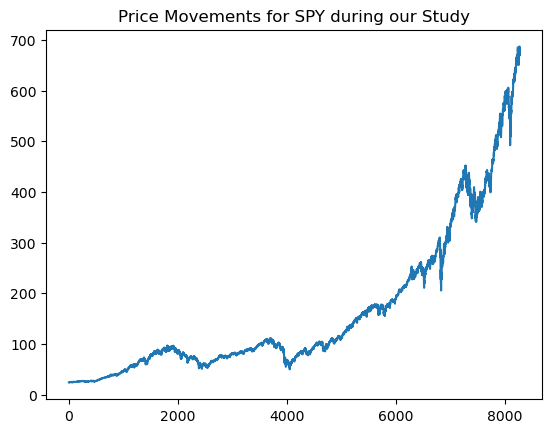

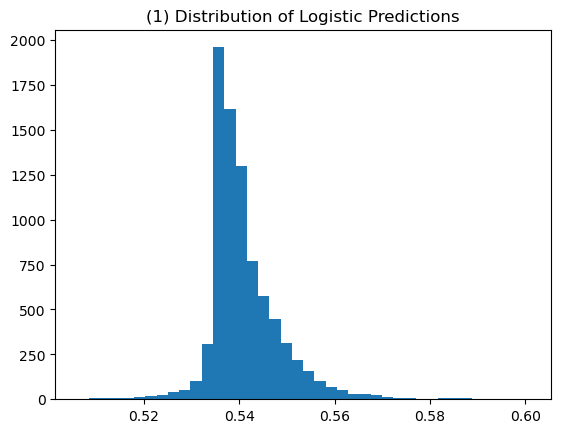

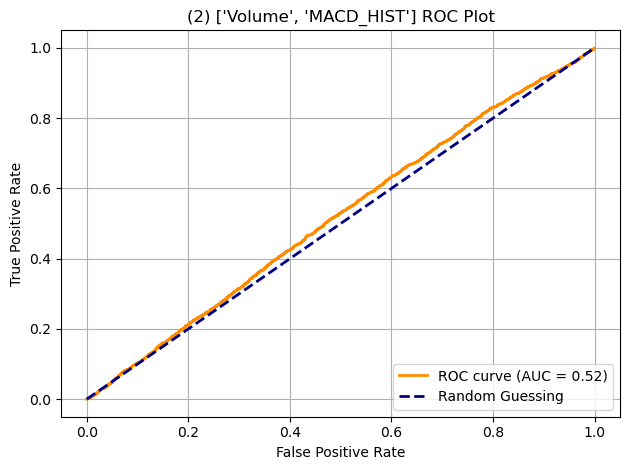

Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_HIST,Close + 1,Target,Prediction
0,24.241405,24.258647,24.137957,24.258647,1003200,24.241405,24.241405,0.000000,0.000000,0.000000,24.413820,1,0
1,24.413820,24.413820,24.258648,24.258648,480500,24.334797,24.330806,0.003991,0.002217,0.001774,24.465546,1,0
2,24.465546,24.482787,24.344856,24.396580,201300,24.385828,24.379085,0.006743,0.004072,0.002671,24.724159,1,0
3,24.724159,24.741401,24.482780,24.500021,529400,24.492626,24.475167,0.017459,0.008607,0.008852,24.827610,1,0
4,24.827610,24.879334,24.534506,24.810369,531500,24.583640,24.556470,0.027170,0.014129,0.013041,24.810371,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8276,678.724426,683.739636,677.248806,683.719676,90811000,680.025839,676.368156,3.657683,3.388161,0.269522,676.869934,0,0
8277,676.869934,679.073445,672.991380,677.228859,122030600,679.540315,676.403997,3.136318,3.337792,-0.201474,669.421936,0,1
8278,669.421936,678.435280,669.222513,677.886913,110625200,677.983641,675.905278,2.078363,3.085906,-1.007543,674.476929,1,1
8279,674.476929,678.734368,672.911608,675.603604,108650100,677.444147,675.803254,1.640894,2.796904,-1.156010,680.590027,1,1


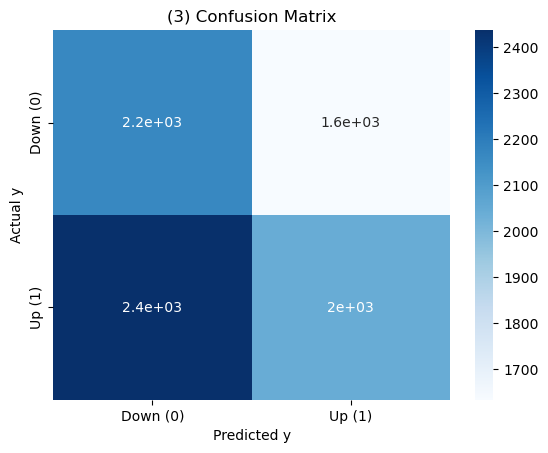

In [ ]:
import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc # pip install scikit-learn
import yfinance_fix

TICKER = "SPY"
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else: 
    PERIOD = "max"

#   MACD
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

#   MFI
MFI_LENGTH = 14 
OVERBROUGHT = 70
OVERSOLD = 30 

#   BB
BB_LENGTH = 20
STD_DEV = 2

#   RSI
RSI_LENGTH = 14
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30

STRATEGY = ["Volume", "MACD_HIST"]
SHIFT = 1 
LOOKBACK = 10000
#SESSION = requests.Session(impersonate="chrome")

def get_data(ticker = TICKER,interval = INTERVAL, lookback = LOOKBACK):

    df = yf.download(ticker, interval = interval, session=yfinance_fix.chrome_session, period = PERIOD)
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

    if df.empty:
        print(f"WARNUNG: Keine Daten für {ticker} erhalten!")
        return df # Gibt leeren DF zurück, damit main() das abfangen kann

    plt.figure()
    plt.plot(df["Close"])
    plt.title(f"Price Movements for {ticker} during our Study")

    return df.iloc[-lookback:, :]

# Add Features
def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):

    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()

    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]

    df["Signal"] = df[f"MACD"].ewm(span = span).mean()

    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    return df

# Add Target 
def add_target(df, shift = SHIFT):

    df[f"Close + {shift}"] = df["Close"].shift(-shift)
    df["Target"] = (df[f"Close + {shift}"] > df["Close"]) * 1

    return df

# --- (5) Generate Regression Output ---
def generate_regression_output(df, features=STRATEGY, target="Target"):

    subset = df[features + [target]].dropna()
    print(subset.columns)
    X = subset[features] 
    y = subset[target] 
    X_with_const = sm.add_constant(X)
    
    model = sm.Logit(y, X_with_const).fit()

    # We need the predicted Values of y. 
    y_pred_prob = model.predict(X_with_const)
    plt.figure()
    plt.hist(y_pred_prob, bins = 40)
    plt.title("(1) Distribution of Logistic Predictions")
    ## Everything left to 0.5 will be a 0 and everything right to 0.5 will be a 1
    # A perefct distribution would be ceneterd around 0.5, but that is rare, because most datasets are skewed

    y_pred = (y_pred_prob > .54).astype(int) # List of responses that are either 0 or 1
    # we can change our cutoff to above the mean, .54 and with that we can actually have a better distribution, 
    # as well as a confucion matrix, so the model becomes a little bit more useful 
    
    # Console Summary
    print(model.summary())
    df["Prediction"] = y_pred

    return df, y, y_pred_prob


def add_confusion_matrix(df):

    cm = confusion_matrix(df["Target"], df["Prediction"])
    labels = ["Down (0)", "Up (1)"]

    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure()

    sns.heatmap(cm_df, annot = True, cmap = "Blues")
    plt.title("(3) Confusion Matrix")
    plt.xlabel("Predicted y")
    plt.ylabel("Actual y")

    return df

# ROC: Receiver Operating Characteristic Plot for Logistic Regression
def add_roc_plot(df, y_true, y_scores, title=f"(2) {STRATEGY} ROC Plot"):

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--", label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df

def main():

    df = get_data()
    df = add_MACD(df)
    df = add_target(df)
    df, y, y_pred_prob = generate_regression_output(df)
    df = add_roc_plot(df, y_true=y, y_scores=y_pred_prob)
    df = add_confusion_matrix(df)

    return df 

df = main()
df


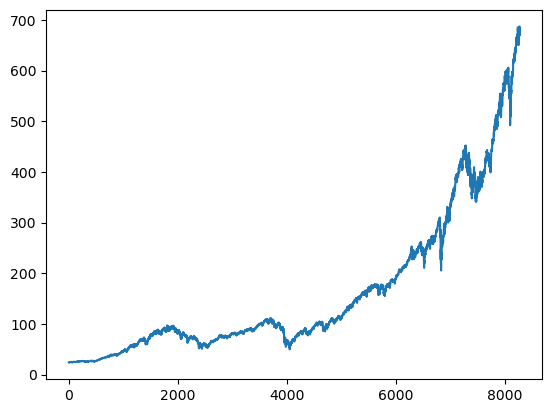

In [2]:
# Lets examine the Environment of our Study
plt.plot(df["Close"])
# As we can see, more often than not, the prices go up more than they go down 

In [3]:
df["Prediction"].value_counts()
# Down Days are rare, but they do stillm exist

Prediction
0    4604
1    3677
Name: count, dtype: int64